In [1]:
import os
os.environ["SDSS_LOCAL_SAS_MIRROR"]="/data/jdli/sdss/"
os.environ["RESULTS_VERS"]="dr17"
os.environ["GAIA_TOOLS_DATA"]="/data/jdli/gaia/"

%matplotlib inline
%load_ext autoreload
%autoreload 2
from pylab import *

from astropy.table import Table, join
from astropy.io import fits
from tqdm import tqdm
import numpy as np
import pandas as pd



In [2]:
%matplotlib inline
%config InlineBackend.figure_format = "retina"
import matplotlib
from matplotlib import rcParams
import matplotlib.pyplot as plt
rcParams["savefig.dpi"] = 100
rcParams["figure.dpi"] = 100
rcParams["font.size"] = 16

import numpy as np
import pandas as pd
from tqdm import tqdm
import cmasher as cmr

from matplotlib import colors

In [3]:
from astroquery.gaia import Gaia


In [5]:
Gaia.login()
# jli06
# zwHD5BFFcbT@HZW

INFO: Login to gaia TAP server [astroquery.gaia.core]


User:  jli06
Password:  ········


401 Error 401:
<!doctype html><html lang="en"><head><title>HTTP Status 401 – Unauthorized</title><style type="text/css">body {font-family:Tahoma,Arial,sans-serif;} h1, h2, h3, b {color:white;background-color:#525D76;} h1 {font-size:22px;} h2 {font-size:16px;} h3 {font-size:14px;} p {font-size:12px;} a {color:black;} .line {height:1px;background-color:#525D76;border:none;}</style></head><body><h1>HTTP Status 401 – Unauthorized</h1><hr class="line" /><p><b>Type</b> Status Report</p><p><b>Message</b> Unauthorized</p><p><b>Description</b> The request has not been applied because it lacks valid authentication credentials for the target resource.</p><hr class="line" /><h3>Apache Tomcat/8.5.57</h3></body></html>


ERROR: Error logging in TAP server [astroquery.gaia.core]


In [263]:
# cat = Table.read(os.environ["SDSS_LOCAL_SAS_MIRROR"]+"/dr17/ap17_gdr3_tm_wise_tr.fits")
cat = Table.read(os.environ["GAIA_TOOLS_DATA"]+"ap17_gdr3_tm_wise_tr.fits")


names = [name for name in cat.colnames if len(cat[name].shape)<=1]
df_raw = cat[names].to_pandas()
print(df_raw.shape, df_raw.columns)

(88325, 93) Index(['APOGEE_ID', 'TELESCOPE', 'FIELD', 'ALT_ID', 'RA', 'DEC', 'GLON',
       'GLAT', 'J', 'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR', 'AK_TARG',
       'AK_TARG_METHOD', 'AK_WISE', 'SFD_EBV', 'SNR', 'SNREV', 'STARFLAG',
       'STARFLAGS', 'ANDFLAG', 'ANDFLAGS', 'VHELIO_AVG', 'VSCATTER', 'VERR',
       'GAIAEDR3_SOURCE_ID', 'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
       'GAIAEDR3_PMRA', 'GAIAEDR3_PMRA_ERROR', 'GAIAEDR3_PMDEC',
       'GAIAEDR3_PMDEC_ERROR', 'GAIAEDR3_PHOT_G_MEAN_MAG',
       'GAIAEDR3_PHOT_BP_MEAN_MAG', 'GAIAEDR3_PHOT_RP_MEAN_MAG',
       'GAIAEDR3_DR2_RADIAL_VELOCITY', 'GAIAEDR3_DR2_RADIAL_VELOCITY_ERROR',
       'GAIAEDR3_R_MED_GEO', 'GAIAEDR3_R_LO_GEO', 'GAIAEDR3_R_HI_GEO',
       'GAIAEDR3_R_MED_PHOTOGEO', 'GAIAEDR3_R_LO_PHOTOGEO',
       'GAIAEDR3_R_HI_PHOTOGEO', 'ASPCAPFLAG', 'ASPCAPFLAGS', 'TEFF',
       'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'M_H', 'M_H_ERR', 'ALPHA_M',
       'ALPHA_M_ERR', 'VSINI', 'source_id', 'visibility_periods_used', 'ruwe',
    

In [623]:
df_raw['tmass_id'] = [s.decode('utf-8').strip() for s in df_raw['APOGEE_ID']]

df_raw['tmass_id']

0        2M00000032+5737103
1        2M00000068+5710233
2        2M00000546+6152107
3        2M00000866+7122144
4        2M00001199+6114138
                ...        
88320    2M23595484+5711289
88321    2M23595490+5704387
88322    2M23595538+6442561
88323    2M23595606+6251121
88324    2M23595676+7918072
Name: tmass_id, Length: 88325, dtype: object

In [266]:

df_raw['Qfl_J'] = [s.decode('utf-8')[0] for s in df_raw['Qfl']]
df_raw['Qfl_H'] = [s.decode('utf-8')[1] for s in df_raw['Qfl']]
df_raw['Qfl_K'] = [s.decode('utf-8')[1] for s in df_raw['Qfl']]


In [264]:
df_raw['qph_w1'] = [s.decode('utf-8')[0] for s in df_raw['qph']]
df_raw['qph_w2'] = [s.decode('utf-8')[1] for s in df_raw['qph']]


In [11]:
def chunks(lst, n):
    ""
    "Split an input list into multiple chunks of size =< n"
    ""
    for i in range(0, len(lst), n):
        yield lst[i:i+n]
        
        
dl_threshold = 5000               # DataLink server threshold. It is not possible to download products for more than 5000 sources in one single call.
ids          = cat['GAIAEDR3_SOURCE_ID']
ids_chunks   = list(chunks(ids, dl_threshold))
datalink_all = []


print(f'* Input list contains {len(ids)} source_IDs')
print(f'* This list is split into {len(ids_chunks)} chunks of <= {dl_threshold} elements each')



* Input list contains 88325 source_IDs
* This list is split into 18 chunks of <= 5000 elements each


In [13]:
# retrieval_type = 'XP_SAMPLED'  # Options are: 'EPOCH_PHOTOMETRY', 'MCMC_GSPPHOT', 'MCMC_MSC', 'XP_SAMPLED', 'XP_CONTINUOUS', 'RVS', 'ALL'
retrieval_type = 'XP_CONTINUOUS'
data_structure = 'COMBINED'   # Options are: 'INDIVIDUAL', 'COMBINED', 'RAW'
data_release   = 'Gaia DR3' # Options are: 'Gaia DR3' (default), 'Gaia DR2'
dl_key         = f'{retrieval_type}_{data_structure}.xml'

datalink_all = []

# dl_keys  = [inp for inp in datalink.keys()]
# dl_keys.sort()

ii = 0
for chunk in ids_chunks:
    ii+=1
    print(f'Downloading Chunk #{ii}; N_files = {len(chunk)}')
    datalink  = Gaia.load_data(ids=chunk,
                               data_release = data_release, 
                               retrieval_type=retrieval_type, format='votable',
                               data_structure=data_structure)
    
    datalink_all.append(datalink)

In [14]:
product_list_tb  = [item for sublist in datalink_all for item in sublist[dl_key]]
# product_list_ids = [item.get_field_by_id("source_id") for sublist in datalink_all for item in sublist[dl_key]]
product_list_ids = [sid for sublist in datalink_all for item in sublist[dl_key] for sid in item.array["source_id"].data]



In [15]:
from tqdm import tqdm
N_COEFF = 55


bp_coef = []
rp_coef = []
e_bp_coef, e_rp_coef = [], []

i = 0
for kk,tab in tqdm(enumerate(product_list_tb)):
    
    bp_coefficients         = np.array([d.data for d in tab.array["bp_coefficients"]]).reshape(-1, N_COEFF)
    bp_coefficients_errors  = np.array([d.data for d in tab.array["bp_coefficient_errors"]]).reshape(-1, N_COEFF)


    rp_coefficients         = np.array([d.data for d in tab.array["rp_coefficients"]]).reshape(-1, N_COEFF)
    rp_coefficients_errors  = np.array([d.data for d in tab.array["rp_coefficient_errors"]]).reshape(-1, N_COEFF)
    
    bp_coef.append(bp_coefficients)
    rp_coef.append(rp_coefficients)
    
    e_bp_coef.append(bp_coefficients_errors)
    e_rp_coef.append(rp_coefficients_errors)
    
    
bp_coef = np.vstack(tuple([_ for _ in bp_coef]))
rp_coef = np.vstack(tuple([_ for _ in rp_coef]))
e_bp_coef = np.vstack(tuple([_ for _ in e_bp_coef]))
e_rp_coef = np.vstack(tuple([_ for _ in e_rp_coef]))

print(bp_coef.shape, rp_coef.shape, e_bp_coef.shape, e_rp_coef.shape)
print(len(product_list_ids))

18it [00:01, 10.78it/s]

(82492, 55) (82492, 55) (82492, 55) (82492, 55)
82492


In [514]:

df_xpcontinous = pd.DataFrame(
    {'source_id':product_list_ids, 'bp_coef':bp_coef.tolist(), 
     'e_bp_coef':e_bp_coef.tolist(), 'rp_coef':rp_coef.tolist(),  
     'e_rp_coef':e_rp_coef.tolist()}
)

df_xpcontinous = df_xpcontinous.merge(
    df_raw[[
        'GAIAEDR3_SOURCE_ID', 'J', 'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR', 
        'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR', 'GAIAEDR3_PHOT_G_MEAN_MAG',
       'GAIAEDR3_PHOT_BP_MEAN_MAG', 'GAIAEDR3_PHOT_RP_MEAN_MAG',
        'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR', 'M_H', 'M_H_ERR', 'ALPHA_M', 'ALPHA_M_ERR',
        'W1mag', 'W2mag', 'W3mag', 'W4mag', 'Jmag', 'Hmag', 'Kmag', 'e_W1mag', 'e_W2mag',
        'qph_w1', 'qph_w2', 'Qfl_J', 'Qfl_H', 'Qfl_K', 'ASPCAPFLAG'
           ]], 
    left_on='source_id', right_on='GAIAEDR3_SOURCE_ID', how='left')

print(df_xpcontinous.shape)

(82492, 40)


In [515]:
df_xpcontinous.head(3)

,source_id,bp_coef,e_bp_coef,rp_coef,e_rp_coef,GAIAEDR3_SOURCE_ID,J,J_ERR,H,H_ERR,...,Hmag,Kmag,e_W1mag,e_W2mag,qph_w1,qph_w2,Qfl_J,Qfl_H,Qfl_K,ASPCAPFLAG
0,422596679964513792,"[15165.617946592545, -1721.5016893849738, -167...","[7.185272693634033, 6.069084644317627, 6.33240...","[17227.957026839962, -1817.282988426649, -35.5...","[3.2178711891174316, 2.9909799098968506, 2.942...",422596679964513792,10.905,0.023,10.635,0.030,...,10.635,10.483,0.023,0.020,A,A,A,A,A,0
1,421077597267551104,"[13599.182856690079, -397.6847455603626, -483....","[6.693983554840088, 5.800073623657227, 6.00819...","[18101.9083107185, -1344.4251895509801, 52.458...","[3.442444086074829, 3.2309682369232178, 3.1673...",421077597267551104,10.664,0.023,10.132,0.030,...,10.132,10.018,0.023,0.020,A,A,A,A,A,0
2,429530195985183744,"[15412.297633348438, 3440.7151938417455, -587....","[10.154775619506836, 8.61961555480957, 9.59582...","[44553.06993052493, 5313.520665960605, 469.455...","[7.244657516479492, 6.703298568725586, 6.77615...",429530195985183744,9.013,0.063,8.029,0.057,...,8.029,7.745,0.043,0.033,A,A,A,A,A,0


In [516]:
xp_df = pd.DataFrame(np.c_[bp_coef, e_bp_coef, rp_coef, e_rp_coef, 
                           df_xpcontinous['GAIAEDR3_PHOT_G_MEAN_MAG'].values])

In [473]:

xp_continuous = pd.DataFrame(
    {'source_id':product_list_ids,
     'bp_coefficients':bp_coef.tolist(), 'bp_coefficient_errors':e_bp_coef.tolist(), 
     'rp_coefficients':rp_coef.tolist(), 'rp_coefficient_errors':e_rp_coef.tolist(), 
     'bp_basis_function_id': [56 for _ in range(len(product_list_ids))], 
     'rp_basis_function_id': [56 for _ in range(len(product_list_ids))], 
    }
)

# xp_continuous.to_csv(data_dir+"ap_xp_continuous.csv", index=False)


In [133]:
bp_coef_snr_map = np.zeros([len(G_grids)-1, n_coef])
rp_coef_snr_map = np.zeros([len(G_grids)-1, n_coef])
num_coeff = np.linspace(1,55,55)


for i, (g, group) in enumerate(xp_df.groupby('G_bin')):
    
    for j in range(n_coef):
        
        bp_coef_snr_map[i,j] = np.median(np.abs(group[j])/group[j+n_coef])
        rp_coef_snr_map[i,j] = np.median(np.abs(group[j+2*n_coef])/group[j+3*n_coef])
        

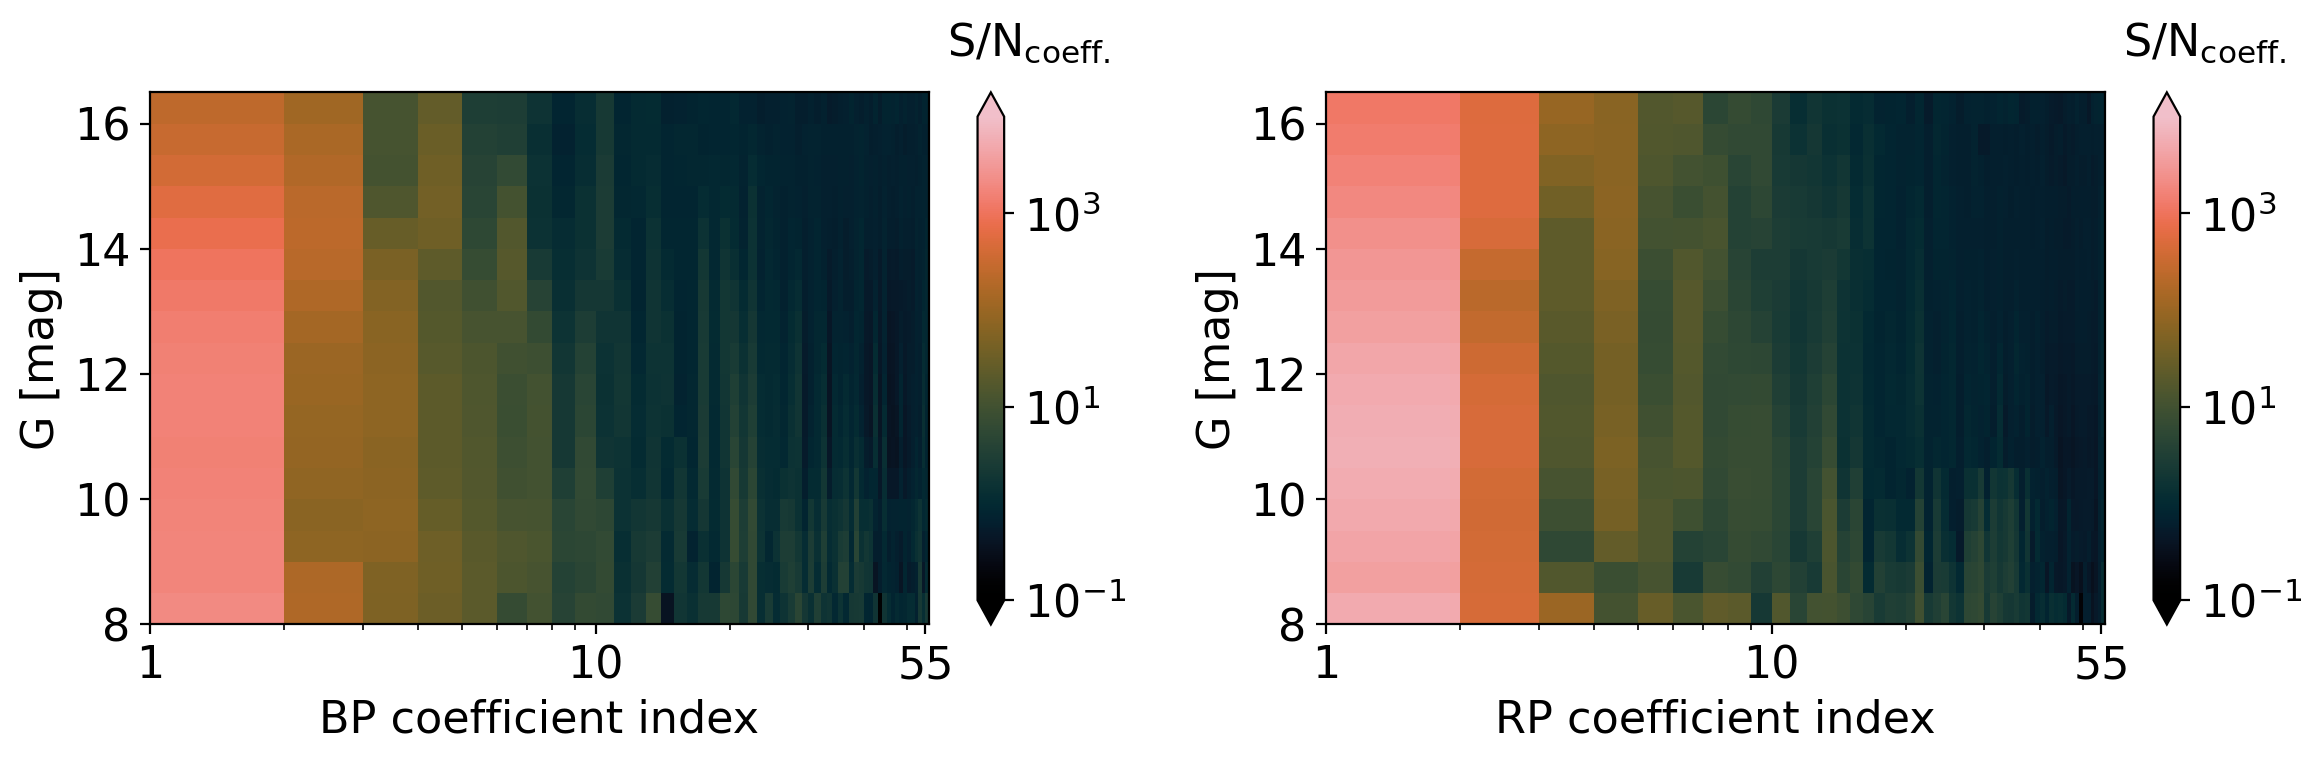

In [424]:
fig, axs = plt.subplots(1,2, figsize=(12,4))
num_coeff_grid = np.linspace(1,56,56)


xx, yy = np.meshgrid(num_coeff_grid, G_grids)
ax1, ax2 = axs.ravel()
img1 = ax1.pcolormesh(
    xx, yy, bp_coef_snr_map, norm=colors.LogNorm(vmin=1e-1, vmax=1e4), 
    cmap='cmr.dusk'
)
img2 = ax2.pcolormesh(
    xx, yy, rp_coef_snr_map, norm=colors.LogNorm(vmin=1e-1, vmax=1e4), 
    cmap='cmr.dusk'
)
ax2.set_xscale('log')
ax1.set_xscale('log')

ax1.set_xticks([1, 10, 55]);
ax2.set_xticks([1, 10, 55]);
ax1.set_xticklabels([1, 10, 55]);
ax2.set_xticklabels([1, 10, 55]);


clb1 = fig.colorbar(img1, ax=ax1, extend='both');
clb2 = fig.colorbar(img2, ax=ax2, extend='both');

clb1.set_label(r"S/N$_{\rm coeff.}$", rotation=0, y=1.2, labelpad=-35)
clb2.set_label(r"S/N$_{\rm coeff.}$", rotation=0, y=1.2, labelpad=-35)

ax1.set_xlabel("BP coefficient index");
ax1.set_ylabel("G [mag]");

ax2.set_xlabel("RP coefficient index");
ax2.set_ylabel("G [mag]");

plt.tight_layout()

# fig.savefig("../fig/coef_Gmag_snr.pdf")
fig.savefig("../fig/coef_Gmag_snr.png")

In [123]:
# cmap = plt.get_cmap('cmr.rainforest')
# norm = colors.Normalize(vmin=10, vmax=17)

# c_Gmag = [cmap(norm(G)) for G in df_xpcontinous['GAIAEDR3_PHOT_G_MEAN_MAG']]

In [526]:
data_dir = "/data/jdli/gaia/"

raw_mask = (df_xpcontinous['M_H']>-3) & (df_xpcontinous['M_H']<1) &\
        (df_xpcontinous['TEFF']>2000) & (df_xpcontinous['TEFF']<7000) &\
        (df_xpcontinous['ALPHA_M']>-1) & (df_xpcontinous['ALPHA_M']<1) &\
        (df_xpcontinous['W1mag']>2) & (df_xpcontinous['W1mag']<20.) &\
        (df_xpcontinous['W2mag']>2) & (df_xpcontinous['W2mag']<20.) &\
        (df_xpcontinous['qph_w1']=='A') & (df_xpcontinous['qph_w2']=='A')

print(df_xpcontinous[raw_mask].shape)

data_cont ={'bp_coef':np.array([np.array(_) for _ in df_xpcontinous['bp_coef'].values[raw_mask]]).reshape(len(df_xpcontinous[raw_mask]), -1), 
            'rp_coef':np.array([np.array(_) for _ in df_xpcontinous['rp_coef'].values[raw_mask]]).reshape(len(df_xpcontinous[raw_mask]), -1), 
            'e_bp_coef':np.array([np.array(_) for _ in df_xpcontinous['e_bp_coef'].values[raw_mask]]).reshape(len(df_xpcontinous[raw_mask]), -1),
            'e_rp_coef':np.array([np.array(_) for _ in df_xpcontinous['e_rp_coef'].values[raw_mask]]).reshape(len(df_xpcontinous[raw_mask]), -1),
            'df':df_xpcontinous[raw_mask]}



(81347, 40)


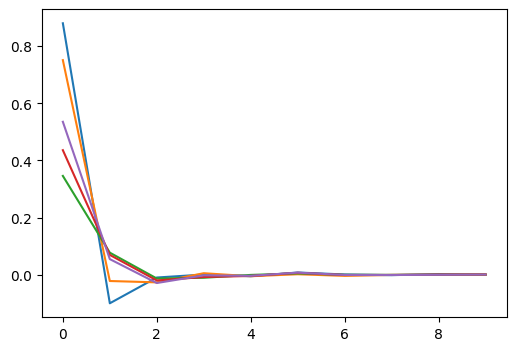

In [244]:
idx_lst = [0, 10, 100, 1000, 10000]
fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# from sklearn import preprocessing
# scaler_bp = preprocessing.RobustScaler()
# scaler_rp = preprocessing.RobustScaler()

# scaler_bp.fit(bp_coef[mask])
# scaler_rp.fit(rp_coef[mask])
norm = data_cont['rp_coef'][:,0]
for i,idx in enumerate(idx_lst):
    # yy_bp = scaler_bp.transform(bp_coef[mask])[idx]
    # yy_rp = scaler_bp.transform(rp_coef[mask])[idx]
    # print(yy_bp, yy_rp)
    xx = np.arange(10)
    ax.plot(
        xx, 
        data_cont['bp_coef'][i,:10]/norm[i]
        # np.log10(data_cont['bp_coef'][i,:8]+6*1e4),
    )
    # ax.plot(
    #     xx, np.log10(data_cont['rp_coef'][i,:8]+6*1e4),
    # )

In [ ]:
from sklearn import preprocessing
import joblib

scaler_bp = joblib.load('models/scaler_bp.gz')
scaler_rp = joblib.load('models/scaler_rp.gz')

idx_lst = [0, 10, 100, 1000, 10000]

fig, ax = plt.subplots(1, 1, figsize=(6, 4))

# scaler_bp = preprocessing.RobustScaler(quantile_range=(14., 86.))
# scaler_rp = preprocessing.RobustScaler(quantile_range=(14., 86.))

# joblib.dump(scaler_bp, 'models/scaler_bp.gz')
# joblib.dump(scaler_rp, 'models/scaler_rp.gz')

norm_bp = scaler_bp.transform(np.log10(data_cont['bp_coef']+6*1e4))
norm_rp = scaler_rp.transform(np.log10(data_cont['rp_coef']+6*1e4))

data_cont.update(norm_bp_coef=norm_bp, norm_rp_coef=norm_rp)


In [527]:
def l2norm(y):
    return np.sqrt(np.sum(y**2, axis=1))


snr_bp = l2norm(data_cont['bp_coef'])/l2norm(data_cont['e_bp_coef'])
snr_rp = l2norm(data_cont['rp_coef'])/l2norm(data_cont['e_rp_coef'])


snr_bp_10 = l2norm(data_cont['bp_coef'][:,:10])/l2norm(data_cont['e_bp_coef'][:,:10])
snr_rp_10 = l2norm(data_cont['rp_coef'][:,:10])/l2norm(data_cont['e_rp_coef'][:,:10])


snr_bp_55 = l2norm(data_cont['bp_coef'][:,10:55])/l2norm(data_cont['e_bp_coef'][:,10:55])
snr_rp_55 = l2norm(data_cont['rp_coef'][:,10:55])/l2norm(data_cont['e_rp_coef'][:,10:55])


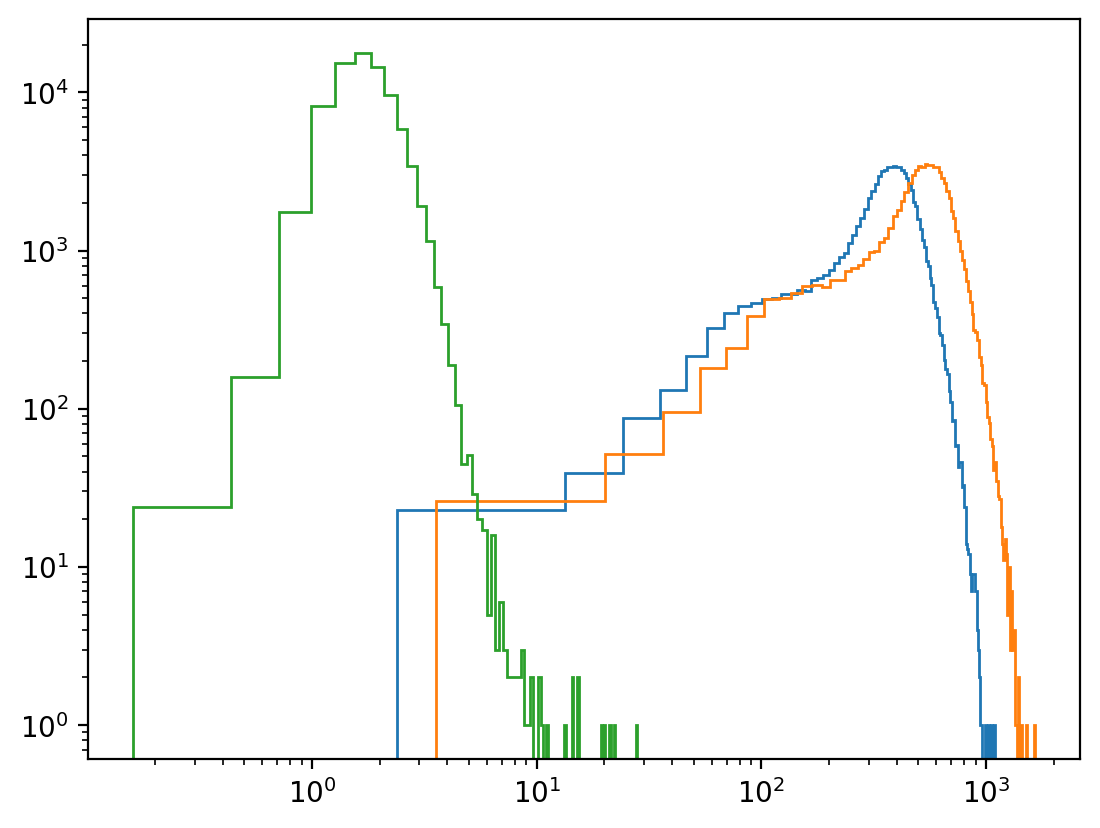

In [595]:
plt.hist(snr_bp, histtype='step', bins=100);
plt.hist(snr_bp_10, histtype='step', bins=100);
plt.hist(snr_bp_55, histtype='step', bins=100);
plt.xscale('log')
plt.yscale('log')

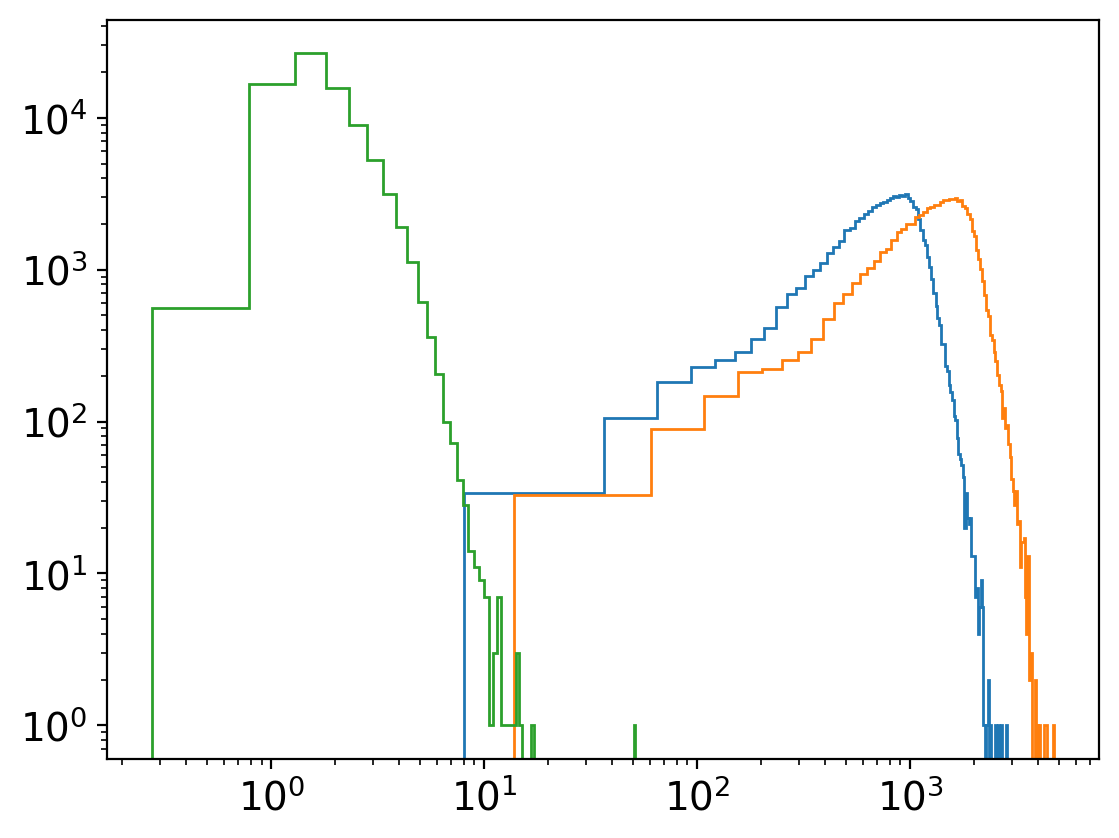

In [529]:
plt.hist(snr_rp, histtype='step', bins=100);
plt.hist(snr_rp_10, histtype='step', bins=100);
plt.hist(snr_rp_55, histtype='step', bins=100);
plt.xscale('log')
plt.yscale('log')

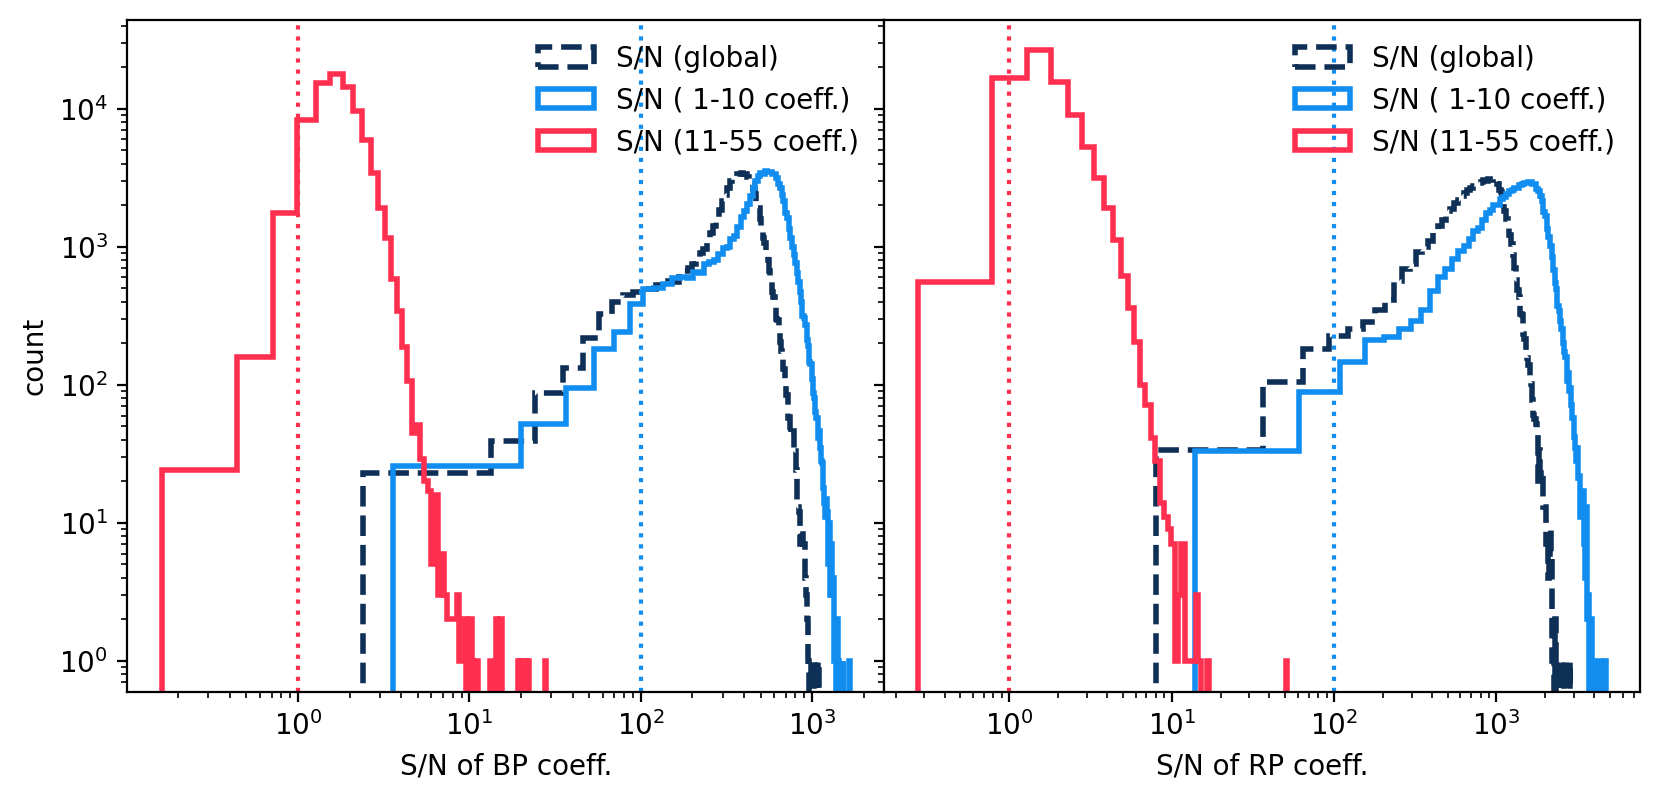

In [609]:
fig, axs = plt.subplots(1,2, figsize=(8.5, 4),  sharey=True)
ax1, ax2 = axs.ravel()

color_palatte = ["#0e2f56", "#118df0", "#ff304f"]
snrbp_lst = [snr_bp, snr_bp_10, snr_bp_55]
snrrp_lst = [snr_rp, snr_rp_10, snr_rp_55]
legends   = ['S/N (global)', 'S/N ( 1-10 coeff.)', 'S/N (11-55 coeff.)']
line_styles = ['--', '-', '-']
snr_cut = [np.nan, 100, 1]

for i in range(3):
    ax1.hist(snrbp_lst[i], histtype='step', bins=100, color=color_palatte[i], 
             lw=2, ls=line_styles[i], label=legends[i]
             );
    ax2.hist(snrrp_lst[i], histtype='step', bins=100, color=color_palatte[i], 
             lw=2, ls=line_styles[i], label=legends[i]
            );
    if i>0:
        ax1.axvline(snr_cut[i], color=color_palatte[i], ls=':')
        ax2.axvline(snr_cut[i], color=color_palatte[i], ls=':')

ax1.set_xlabel("S/N of BP coeff.");
ax2.set_xlabel("S/N of RP coeff.");
ax1.set_ylabel("count");

for ax in axs.ravel():
    ax.set_xscale('log')
    ax.set_yscale('log') 
    
    ax.legend(loc=1, frameon=False); 

plt.tight_layout()
fig.subplots_adjust(left=0.1, bottom=0.15, right=0.99, top=0.99, wspace=0, hspace=0)
fig.savefig("../fig/snr_hist.pdf")

In [520]:
# np.count_nonzero(snr_rp>500)/len(snr_rp)

In [530]:
data_cont['df'] = data_cont['df'].assign(
    snr_bp=snr_bp, snr_bp10=snr_bp_10, snr_bp55=snr_bp_55, 
    snr_rp=snr_rp, snr_rp10=snr_rp_10, snr_rp55=snr_rp_55
)

print(data_cont['df'].columns)

data_cont.update(df=data_cont['df'])

Index(['source_id', 'bp_coef', 'e_bp_coef', 'rp_coef', 'e_rp_coef',
       'GAIAEDR3_SOURCE_ID', 'J', 'J_ERR', 'H', 'H_ERR', 'K', 'K_ERR',
       'GAIAEDR3_PARALLAX', 'GAIAEDR3_PARALLAX_ERROR',
       'GAIAEDR3_PHOT_G_MEAN_MAG', 'GAIAEDR3_PHOT_BP_MEAN_MAG',
       'GAIAEDR3_PHOT_RP_MEAN_MAG', 'TEFF', 'TEFF_ERR', 'LOGG', 'LOGG_ERR',
       'M_H', 'M_H_ERR', 'ALPHA_M', 'ALPHA_M_ERR', 'W1mag', 'W2mag', 'W3mag',
       'W4mag', 'Jmag', 'Hmag', 'Kmag', 'e_W1mag', 'e_W2mag', 'qph_w1',
       'qph_w2', 'Qfl_J', 'Qfl_H', 'Qfl_K', 'ASPCAPFLAG', 'snr_bp', 'snr_bp10',
       'snr_bp55', 'snr_rp', 'snr_rp10', 'snr_rp55'],
      dtype='object')


# Norm And

In [531]:
norm_andrae = 10**((15.-data_cont['df']['GAIAEDR3_PHOT_G_MEAN_MAG'].values)*0.4)



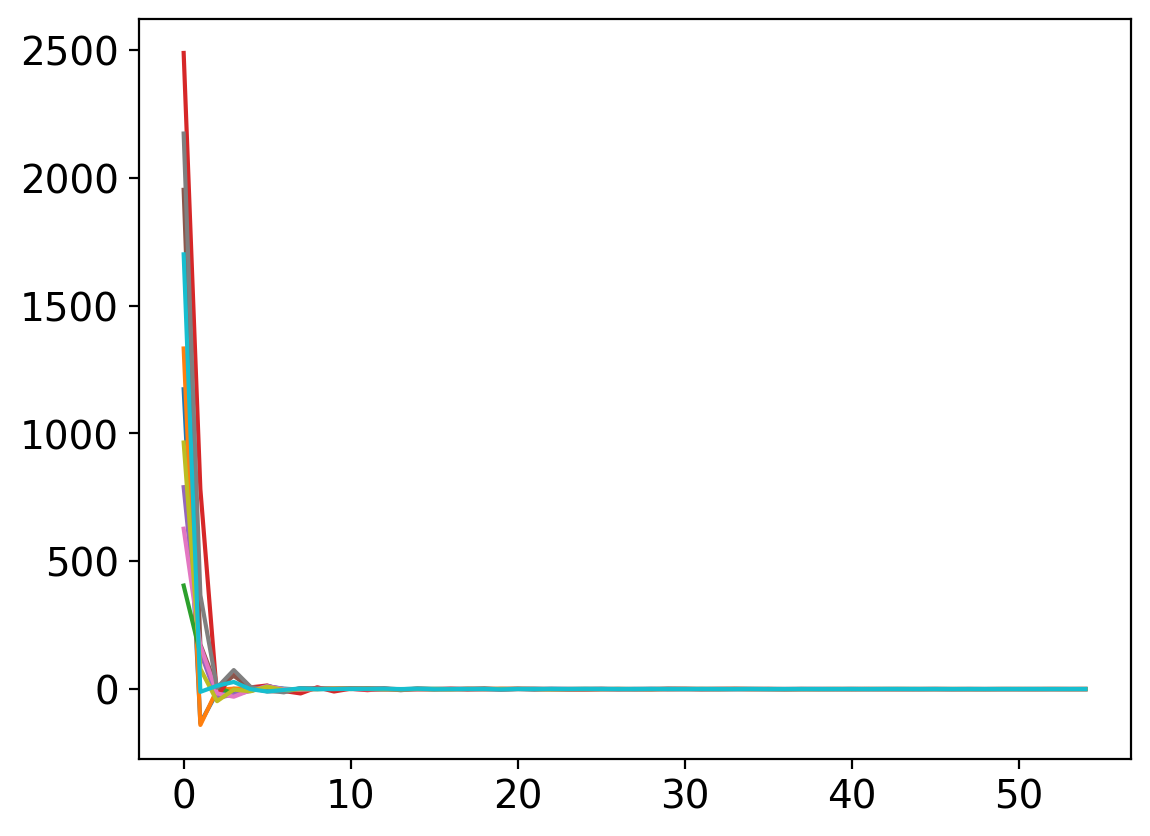

In [532]:
norm_bp_andrae = data_cont['bp_coef']/norm_andrae[:,None]
norm_rp_andrae = data_cont['rp_coef']/norm_andrae[:,None]

idx_lst = [0, 10, 100, 1000, 10000]


for i,idx in enumerate(idx_lst):
    plt.plot(norm_bp_andrae[idx,:x_len])
    plt.plot(norm_rp_andrae[idx,:x_len])

In [282]:
import math

log = np.vectorize(math.log)

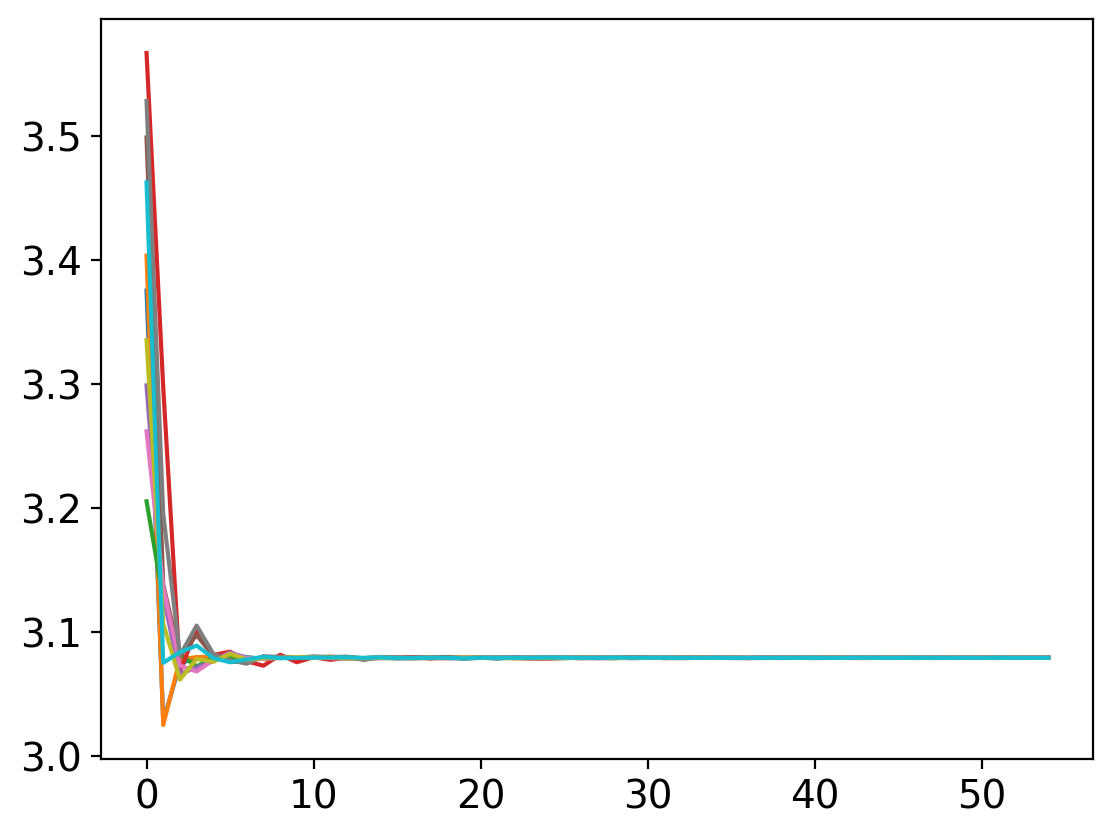

In [283]:
for i,idx in enumerate(idx_lst):
    plt.plot(log(norm_bp_andrae[idx,:55]+1200., 1e1))
    plt.plot(log(norm_rp_andrae[idx,:55]+1200., 1e1))

In [284]:
# lgnorm_bp_andrae = log(norm_bp_andrae+1200., 1e1)
# lgnorm_rp_andrae = log(norm_rp_andrae+1200., 1e1)


# data_cont.update(
#     lgnorm_bp_andrae=lgnorm_bp_andrae,
#     lgnorm_rp_andrae=lgnorm_rp_andrae,
# )

# # np.save(data_dir+"ap17_wise_xpcont_cut.npy", data_cont)

# And normalize + robust normalize

In [713]:
scaler_bp = preprocessing.RobustScaler(quantile_range=(25, 75))
scaler_rp = preprocessing.RobustScaler(quantile_range=(25, 75))
# scaler_bp = preprocessing.RobustScaler(quantile_range=(2.5, 97.5))
# scaler_rp = preprocessing.RobustScaler(quantile_range=(2.5, 97.5))


norm_bp = scaler_bp.fit_transform(norm_bp_andrae)
norm_rp = scaler_rp.fit_transform(norm_rp_andrae)

data_cont.update(norm_bp_coef=norm_bp, norm_rp_coef=norm_rp)

joblib.dump(scaler_bp, 'models/scaler_bp_gmagand_0208.gz')
joblib.dump(scaler_rp, 'models/scaler_rp_gmagand_0208.gz')

# np.save(data_dir+"ap17_wise_xpcont_cut.npy", data_cont)

['models/scaler_rp_gmagand_0208.gz']

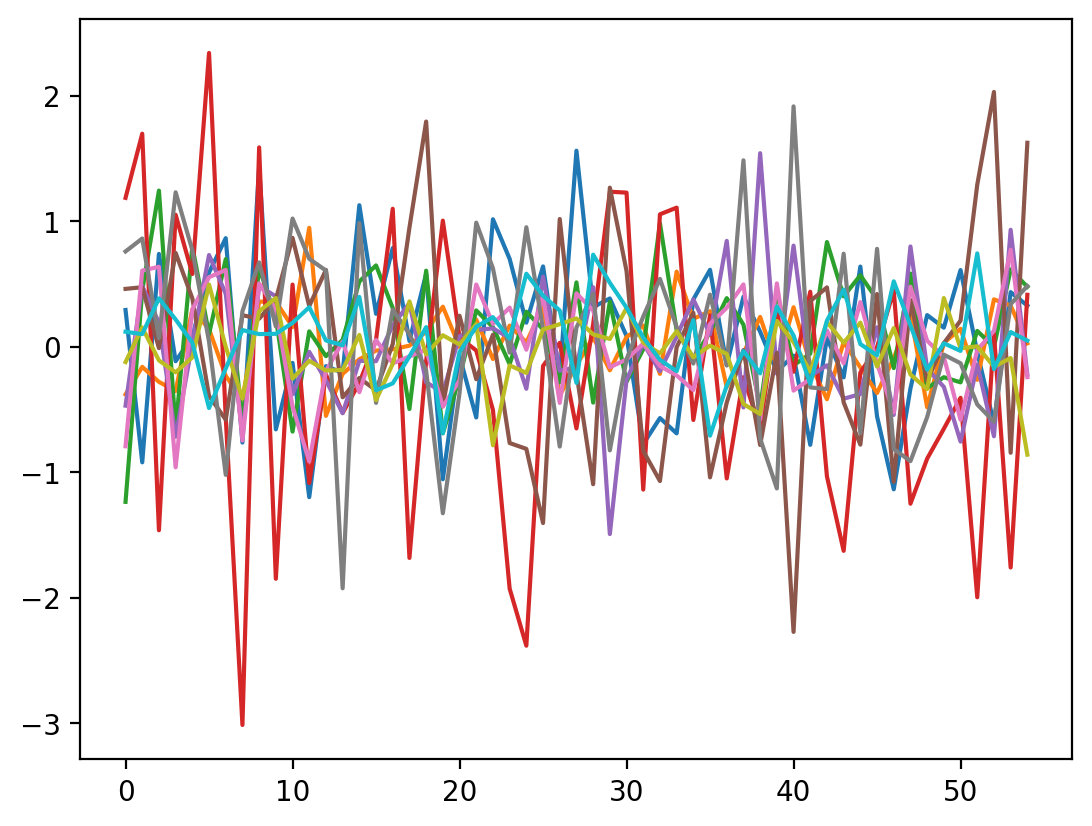

In [700]:
x_len = 55

for i,idx in enumerate(idx_lst):
    # print(yy_bp, yy_rp)
    xx = np.arange(x_len)
    plt.plot(
        xx, norm_bp[idx,:x_len]
    )
    plt.plot(
        xx, norm_rp[idx,:x_len]
    )

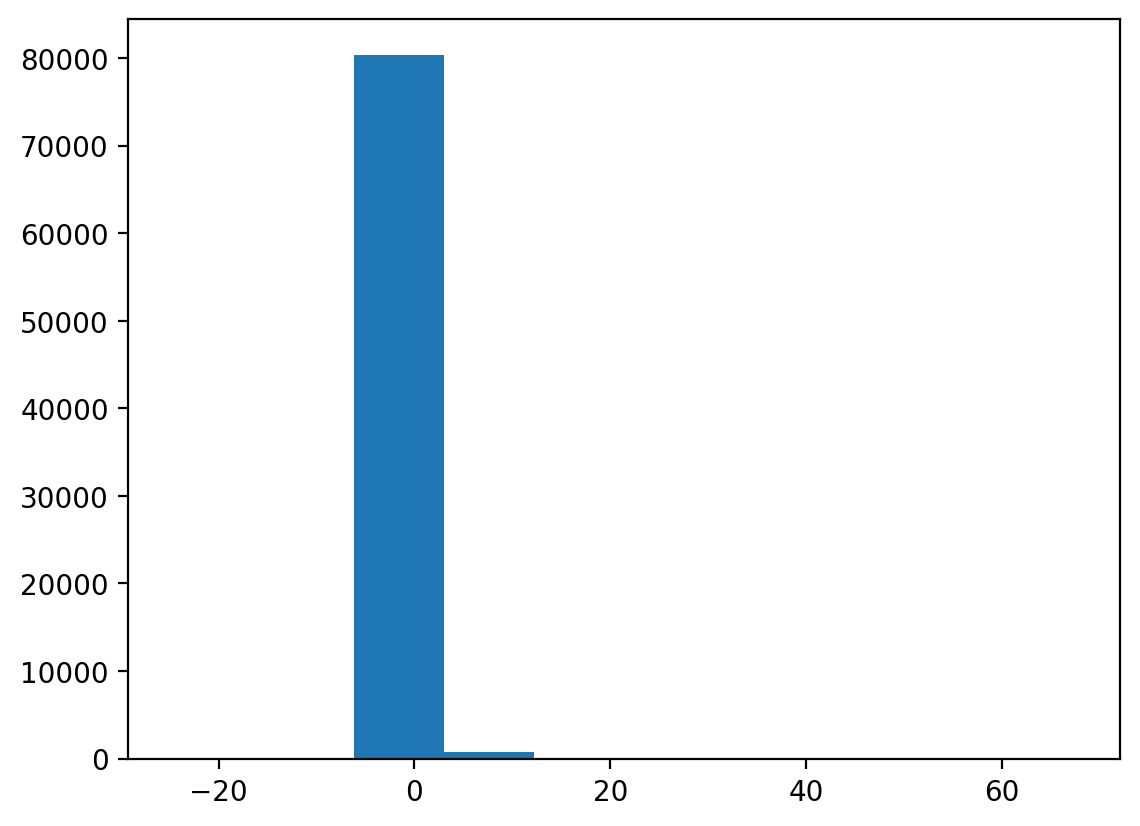

In [714]:
plt.hist(norm_bp[:, 54]);

In [ ]:
plt.hist(norm_bp_andrae[:,54])

In [648]:
gdf = data_cont['df'].copy()
# gdf = pd.read_csv(data_dir+"ap17_gxp_train_81347.csv")
# gdf = gdf.merge(df_raw[['source_id', 'ASPCAPFLAG']])
gdf = gdf.merge(df_raw[['GAIAEDR3_SOURCE_ID', 'tmass_id']])

mask_labels = (gdf['M_H']>-2.5) & (gdf['M_H']<0.6) &\
            (gdf['TEFF']>3000) & (gdf['TEFF']<7000) &\
            (gdf['LOGG']>0.) & (gdf['LOGG']<5.5) &\
            (gdf['ALPHA_M']>-1) & (gdf['ALPHA_M']<1) & (gdf['ASPCAPFLAG']==0) &\
            (gdf['LOGG_ERR']<0.1) & (gdf['TEFF_ERR']<50) &\
            (gdf['ALPHA_M_ERR']<0.02) & (gdf['M_H_ERR']<0.015)

        

mask_photo = (gdf['J']>6) & (gdf['J']<14.) &\
            (gdf['H']>6) & (gdf['H']<14.) &\
            (gdf['K']>6) & (gdf['K']<14.) &\
            (gdf['Qfl_J']=='A') & (gdf['Qfl_H']=='A') & (gdf['Qfl_K']=='A')&\
            (gdf['W1mag']>6) & (gdf['W1mag']<13.) &\
            (gdf['W2mag']>6) & (gdf['W2mag']<13.) &\
            (gdf['qph_w1']=='A') & (gdf['qph_w2']=='A')

mask_spec = (gdf['snr_bp10']>100.) & (gdf['snr_bp55']>1.) &\
            (gdf['snr_rp10']>100.) & (gdf['snr_rp55']>1.)

mask  = mask_labels & mask_photo & mask_spec

print(gdf.shape, gdf[mask_labels].shape, gdf[mask_photo].shape, gdf[mask_spec].shape)
print(gdf[mask].shape)



(81347, 47) (70801, 47) (81166, 47) (75680, 47)
(66695, 47)


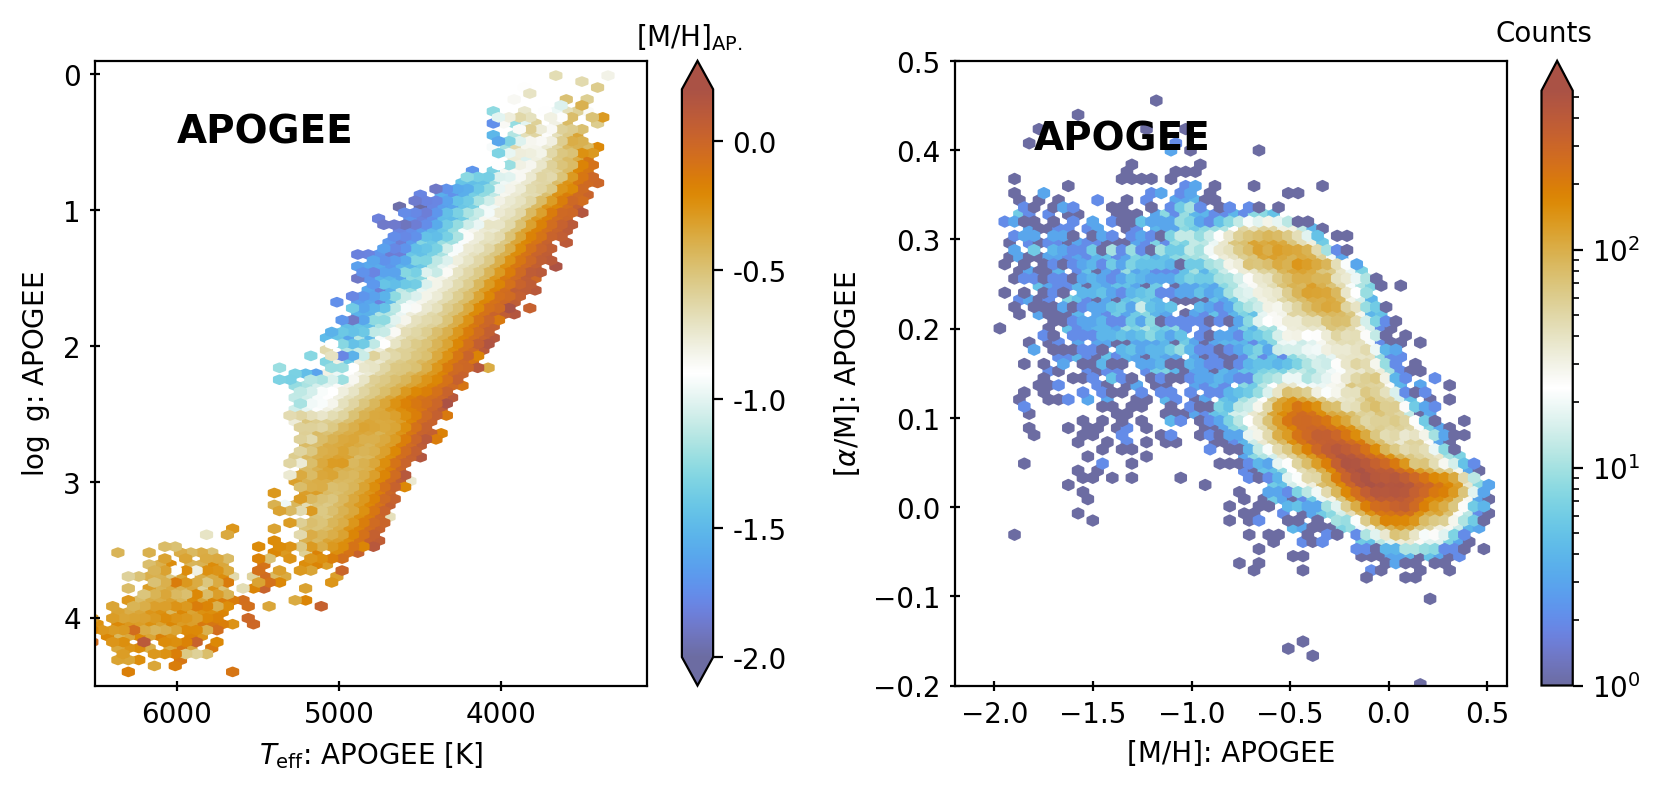

In [613]:
plt.style.use('default')
fig, axs = plt.subplots(1, 2, figsize=(8.5, 4))

mask  = mask_labels & mask_photo & mask_spec

ax3, ax4 = axs.ravel()
ax3, ax4 = draw_pars(
    ax3, ax4,
    gdf['TEFF'][mask].values, gdf['LOGG'][mask].values,
    gdf['M_H'][mask].values,  gdf['ALPHA_M'][mask].values,  
    gridsize=(50, 50)
)

ax3.tick_params(axis="x", direction="inout")
ax3.tick_params(axis="y", direction="inout")
ax4.tick_params(axis="x", direction="inout")
ax4.tick_params(axis="y", direction="inout")
ax4.set_xlim([-2.2, 0.6]);
ax4.set_ylim([-0.2, 0.5]);
ax3.text(6000, 0.5, "APOGEE", zorder=5, fontsize=14, weight='bold')
ax4.text(-1.8, 0.4, "APOGEE", zorder=5, fontsize=14, weight='bold')

plt.tight_layout()

fig.savefig("../fig/tr_labels.pdf")

# Rboust scaler labels

In [587]:
mask  = mask_labels & mask_photo & mask_spec

scaler_labels = preprocessing.RobustScaler(quantile_range=(2.5, 97.5))

labels   = gdf[['TEFF', 'LOGG',  'M_H','ALPHA_M']][mask].values
norm_labels = scaler_labels.fit_transform(labels)


# joblib.dump(scaler_labels, 'models/scaler_labels_0119.gz')

# np.save(data_dir+"ap17_wise_xpcont_cut.npy", data_cont)

['models/scaler_labels_0119.gz']

In [701]:
mask  = mask_labels & mask_photo & mask_spec


e_labels = gdf[['TEFF_ERR', 'LOGG_ERR', 'M_H_ERR', 'ALPHA_M_ERR']][mask].values
norm_e_labels = e_labels / scaler_labels.scale_


photo = gdf[['J', 'H', 'K']].values/gdf['J'][mask].max()
norm_xp = np.c_[data_cont['norm_bp_coef'], data_cont['norm_rp_coef'], photo][mask]


source_id = gdf['source_id'][mask].values


bias = 2.
scale_ext = 10.


save_data = {
    "norm_xp":norm_xp, "labels":(norm_labels+bias)*scale_ext, 
     "e_labels":norm_e_labels*scale_ext, "source_id":source_id
}

fname = "ap17_xp_66695_allstand0119.npy"
np.save(data_dir+fname, save_data)


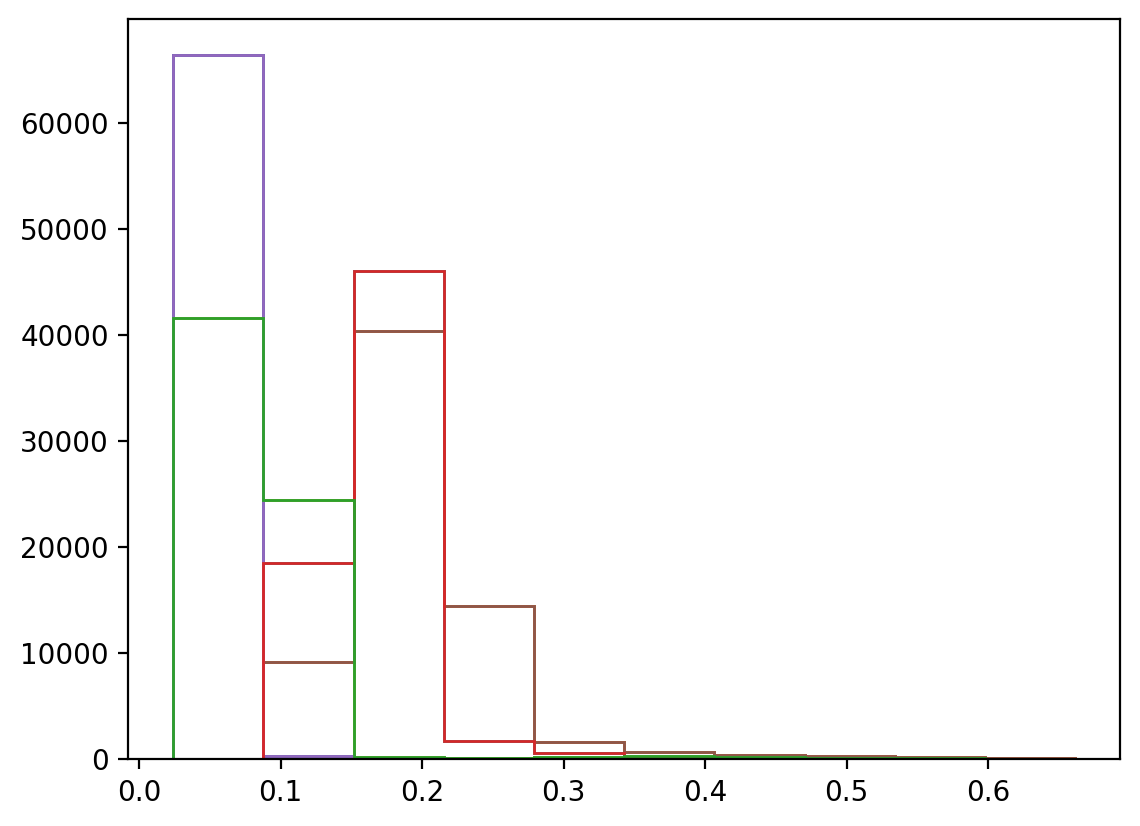

In [702]:
for i in range(4):
    
    plt.hist(save_data['e_labels'], histtype='step')

In [444]:
# mask  = mask_labels & mask_photo & mask_spec

# # photo = gdf[['J','H','K','W1mag','W2mag']].values/gdf['J'].max()
# photo = gdf[['J', 'H', 'K']].values/gdf['J'][mask].max()

# norm_xp = np.c_[data_cont['norm_bp_coef'], data_cont['norm_rp_coef'], photo][mask]
# # andnorm_xp = np.c_[data_cont['lgnorm_bp_andrae'], data_cont['lgnorm_rp_andrae'], photo][mask]

# labels   = gdf[['GAIAEDR3_PARALLAX', 'TEFF', 'LOGG',  'M_H','ALPHA_M']][mask].values
# e_labels = gdf[['GAIAEDR3_PARALLAX_ERROR', 'TEFF_ERR', 'LOGG_ERR', 'M_H_ERR', 'ALPHA_M_ERR']][mask].values


# source_id = gdf['source_id'][mask].values


# norm = np.array([5., 1e-2, 15., 10., 50.]).astype(np.float32)
# shift_norm = np.array([25., 25., 25., 25., 25.]).astype(np.float32)
# labels *= norm
# e_labels *= norm

# labels += shift_norm

# fname = "ap17_wise_xp_70123.npy"
# fname = "ap17_wise_xp_66701.npy"
# fname = "ap17_wise_xp_66701_stand1220.npy"
# np.save(
#     data_dir+fname, 
#     {"norm_xp":norm_xp, "labels":labels, "e_labels":e_labels, 
#      "source_id":source_id}
# )

print(norm_xp.shape, andnorm_xp.shape)
print(labels.shape, e_labels.shape)

(66701, 113) (66701, 113)
(66701, 5) (66701, 5)


In [ ]:
# gdf[mask].to_csv(data_dir+"ap17_gxp_train_66701.csv", index=False)

gdf.to_csv(data_dir+"ap17_gxp_train_81347.csv", index=False)



In [703]:
# apspec_df = pd.read_csv(data_dir+"apsepc_44770.csv", sep='|')
# print(apspec_df.shape, apspec_df.columns)
xp_df = gdf[mask].assign(
    norm_xp=np.c_[data_cont['norm_bp_coef'], data_cont['norm_rp_coef']][mask].tolist(),
)

sdss_dir = "/data/jdli/sdss/"
normspecDict_trlst = np.load(sdss_dir+"hogg19_spec_nnnorm_tr.npy", allow_pickle=True)
normspecDict_vallst = np.load(sdss_dir+"hogg19_spec_nnnorm_val.npy", allow_pickle=True)

a_len, b_len = len(normspecDict_trlst), len(normspecDict_vallst)

apspec_a = pd.DataFrame(
    {
        'norm_spec':[normspecDict_trlst[_]['norm_spec'].flatten().tolist() for _ in range(a_len)],
        'norm_spec_err':[normspecDict_trlst[_]['norm_spec_err'].flatten().tolist() for _ in range(a_len)],
        'tmass_id':[normspecDict_trlst[_]['tmass_id'] for _ in range(a_len)],   
    }
)

apspec_b = pd.DataFrame(
    {
        'norm_spec':[normspecDict_vallst[_]['norm_spec'].flatten().tolist() for _ in range(b_len)],
        'norm_spec_err':[normspecDict_vallst[_]['norm_spec_err'].flatten().tolist() for _ in range(b_len)],
        'tmass_id':[normspecDict_vallst[_]['tmass_id'] for _ in range(b_len)],   
    }
)

apspec = pd.concat([apspec_a, apspec_b], axis=0, ignore_index=True)
print(apspec.shape)

(44771, 3)


In [704]:
ap_xp_df = apspec.merge(xp_df, on='tmass_id')

ap_xp_df.head(3)

,norm_spec,norm_spec_err,tmass_id,source_id,bp_coef,e_bp_coef,rp_coef,e_rp_coef,GAIAEDR3_SOURCE_ID,J,...,Qfl_H,Qfl_K,ASPCAPFLAG,snr_bp,snr_bp10,snr_bp55,snr_rp,snr_rp10,snr_rp55,norm_xp
0,"[1.0, 1.0, 1.0, 1.0483858585357666, 1.05154430...","[1.0, 1.0, 1.0, 0.6077017188072205, 0.29074037...",2M00002118+6136420,429519480056179328,"[1411.122194998899, 356.2594046599496, -46.786...","[1.5237258672714233, 1.2316592931747437, 1.406...","[4659.687837228876, 761.9698733215257, -23.668...","[1.6249879598617554, 1.4459248781204224, 1.497...",429519480056179328,11.154,...,A,A,0,269.571147,369.922543,1.540095,547.347757,965.338820,1.234463,"[-0.7484271780151425, 0.580499109730832, 0.528..."
1,"[0.9008634686470032, 0.9254752397537231, 0.975...","[0.009418211877346039, 0.006968657951802015, 0...",2M00003118+7056365,531237396676133248,"[2406.284433261835, 559.717595613649, -92.3575...","[2.501586437225342, 1.9896681308746338, 2.3080...","[6908.897976140361, 808.4926297175659, 50.1453...","[2.3772361278533936, 2.115065813064575, 2.1798...",531237396676133248,10.977,...,A,A,0,286.917236,390.942524,1.542464,569.996116,976.813940,1.849387,"[-0.6169649643359346, 0.5929606246534795, 0.38..."
2,"[0.9216735363006592, 0.9420937895774841, 0.984...","[0.0028110546991229057, 0.002818293869495392, ...",2M00003157+7059085,531239041643861504,"[5849.873639756224, 1199.6922040093168, -242.4...","[5.197830677032471, 4.313164710998535, 4.85027...","[15528.683453183938, 1553.927419556883, 116.20...","[3.8622350692749023, 3.486895799636841, 3.5552...",531239041643861504,10.134,...,A,A,0,324.967642,447.750862,1.505530,782.883178,1332.154679,2.346754,"[-0.5431042873725388, 0.5318883319677541, 0.29..."


In [705]:
import ast


ap_spec = np.array([_ for _ in ap_xp_df['norm_spec'].values])
print(ap_spec.shape)

xp_coef = np.array([_ for _ in ap_xp_df['norm_xp'].values])
print(xp_coef.shape)


xp_ap = np.hstack((xp_coef, ap_spec))
print(xp_ap.shape)

(13286, 7514)
(13286, 110)
(13286, 7624)


In [706]:
norm_labels = scaler_labels.fit_transform(ap_xp_df[['TEFF','LOGG','M_H','ALPHA_M']])
e_labels = ap_xp_df[['TEFF_ERR', 'LOGG_ERR', 'M_H_ERR', 'ALPHA_M_ERR']].values
norm_e_labels = e_labels / scaler_labels.scale_

source_id = ap_xp_df['source_id'].values

bias = 2.
scale_ext = 10.

save_data = {
    "xp_ap":xp_ap, "labels":(norm_labels+bias)*scale_ext, 
    "e_labels":norm_e_labels*scale_ext, 
    "source_id":source_id
}

fname = "ap_xp_13286.npy"
np.save(data_dir+fname, save_data)

In [707]:
joblib.dump(scaler_labels, 'models/scaler_labels_0208.gz')

['models/scaler_labels_0208.gz']

# save bad XP data

In [374]:
# norm_xp = np.c_[data_cont['norm_bp_coef'], data_cont['norm_rp_coef'], photo][~mask_spec]

# labels   = gdf[['GAIAEDR3_PARALLAX', 'TEFF', 'LOGG',  'M_H','ALPHA_M']][~mask_spec].values
# e_labels = gdf[['GAIAEDR3_PARALLAX_ERROR', 'TEFF_ERR', 'LOGG_ERR', 'M_H_ERR', 'ALPHA_M_ERR']][~mask_spec].values
# source_id = gdf['source_id'][~mask_spec].values


# norm = np.array([5., 1e-2, 15., 10., 50.]).astype(np.float32)
# shift_norm = np.array([25., 25., 25., 25., 25.]).astype(np.float32)
# labels *= norm
# e_labels *= norm

# labels += shift_norm

# fname = "ap17_wise_xp_5667bad.npy"
# np.save(
#     data_dir+fname, 
#     {"norm_xp":norm_xp, "andnorm_xp":andnorm_xp, "labels":labels, "e_labels":e_labels, 
#      "source_id":source_id}
# )

# print(norm_xp.shape)
# print(labels.shape, e_labels.shape)

(5667, 113)
(5667, 5) (5667, 5)


# draw figs

In [ ]:
data_dir = "/data/jdli/gaia/"

gdf = pd.read_csv(data_dir+"ap17_gxp_train_81347.csv")



In [541]:
def draw_coeff(ax1, ax2, bp, rp, teff, cmap='cmr.prinsenvlag_r'):
    # cmap = plt.get_cmap('cmr.pride')
    
    norm = Normalize(vmin=4000, vmax=5000)
    colors_ = [cmap(norm(_)) for _ in teff]
    
    for i,r in enumerate(bp[:500]):
        ax1.plot(r, c=colors_[i], lw=0.5, alpha=0.5)
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    clb1 = plt.colorbar(sm, ax=ax1, ticks=[4000, 4300, 4600, 4900], extend='both')
    clb1.ax.set_yticklabels([4000, 4300, 4600, 4900]) 
    clb1.set_label(r"T$_{\rm eff}$/K", rotation=0, y=1.12, labelpad=-35)
    
    for i,r in enumerate(rp[:500]):
        ax2.plot(r, c=colors_[i], lw=0.5, alpha=0.5)
    
    sm = plt.cm.ScalarMappable(cmap='cmr.prinsenvlag_r', norm=norm)
    sm.set_array([])
    clb2 = plt.colorbar(sm, ax=ax2, ticks=[4000, 4300, 4600, 4900], extend='both')
    clb2.ax.set_yticklabels([4000, 4300, 4600, 4900]) 
    clb2.set_label(r"T$_{\rm eff}$/K", rotation=0, y=1.12, labelpad=-35)
    
    ax1.set_xlabel("Basis index of BP");
    ax1.set_ylabel("Normalized coefficient");
    
    ax2.set_xlabel("Basis index of RP");
    ax2.set_ylabel("Normalized coefficient");

    # ax1.annotate("BP", (0.8, 0.8), xycoords='figure fraction')
    # ax2.annotate("RP", (0.8, 0.8), xycoords='figure fraction')
    ax1.set_xticks(np.arange(1,11,1));
    ax2.set_xticks(np.arange(1,11,1));
    ax1.set_xticklabels(np.arange(1,11,1));
    ax2.set_xticklabels(np.arange(1,11,1));

    return ax1, ax2

def draw_pars(ax1, ax2, teff, logg, moh, aom, gridsize=(50,50)):
    cmap = plt.get_cmap('cmr.prinsenvlag_r')
    img1 = ax1.hexbin(teff, logg, C=moh, cmap='cmr.prinsenvlag_r', gridsize=gridsize)
    # ax2.set_xscale('log')
    ax1.set_xlim([6500, 3100]);
    ax1.set_ylim([4.5, -0.1]);
    
    img2 = ax2.hexbin(moh, aom, gridsize=gridsize, 
                      norm=colors.LogNorm(), cmap='cmr.prinsenvlag_r', )
    ax2.set_xlim([-2.5, 0.5]);
    ax2.set_ylim([-0.3, 0.5]);
    
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=colors.Normalize(-2, 0.2))
    sm.set_array([])
    clb1 = plt.colorbar(sm, ax=ax1, extend='both', ticks=[-2.0, -1.5, -1.0, -0.5, 0.0]);
    clb1.ax.set_yticklabels([-2.0, -1.5, -1.0, -0.5, 0.0]) 
    clb1.set_label(r"[M/H]$_{\rm AP.}$", rotation=0, y=1.12, labelpad=-35)
    
    clb2 = fig.colorbar(img2, ax=ax2, extend='max');
    clb2.set_label(r"Counts", rotation=0, y=1.12, labelpad=-35)
    ax1.set_xlabel(r"$T_{\rm eff}$: APOGEE [K]");
    ax1.set_ylabel(r"$\log$ g: APOGEE");
    ax2.set_xlabel('[M/H]: APOGEE');
    ax2.set_ylabel(r'[$\alpha$/M]: APOGEE');
    return ax1, ax2

# fig, axs = plt.subplots(2, 2, figsize=(12,10))

# ax1, ax2, ax3, ax4 = axs.ravel()

# # ax1, ax2 = draw_coeff(ax1, ax2, andnorm_xp[:,:10], andnorm_xp[:,55:65], gdf['TEFF'][mask].values)
# ax3, ax4 = draw_pars(
#     ax3, ax4,
#     gdf['TEFF'][mask].values, gdf['LOGG'][mask].values,
#     gdf['M_H'][mask].values,  gdf['ALPHA_M'][mask].values
# )

# plt.tight_layout()
# fig.savefig("../fig/tr_xp.pdf")

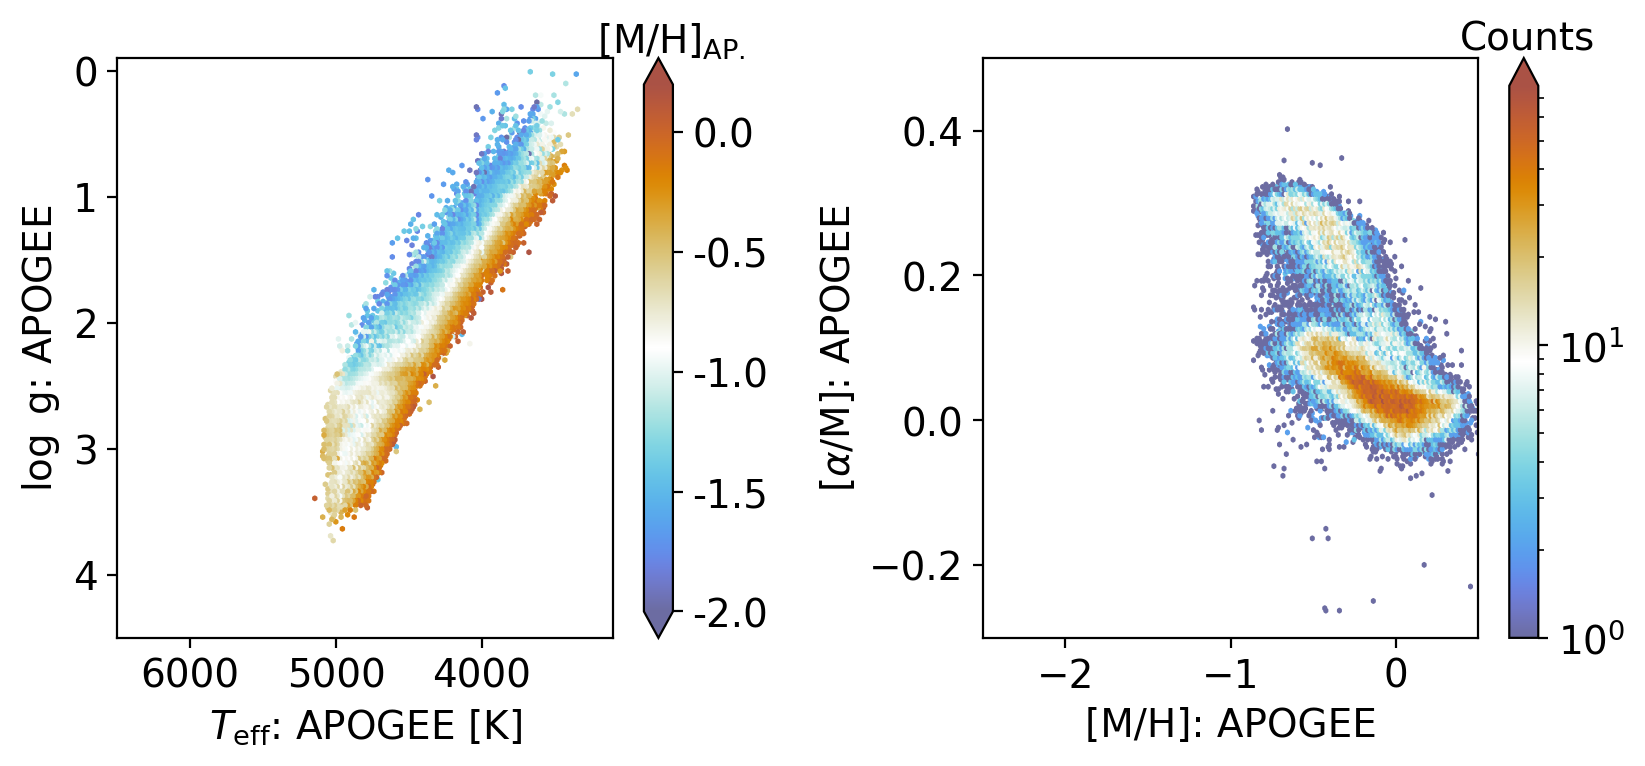

In [557]:
# plt.style.use('default')

rcParams["font.size"] = 14
rcParams['font.family'] = 'sans-serif'

fig, axs = plt.subplots(1, 2, figsize=(8.5,4))

ax3, ax4 = axs.ravel()

ax3, ax4 = draw_pars(
    ax3, ax4,
    gdf['TEFF'][mask].values, gdf['LOGG'][mask].values,
    gdf['M_H'][mask].values,  gdf['ALPHA_M'][mask].values,
     gridsize=(100,100)
)

plt.tight_layout()

# fig.savefig()